In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import warnings

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

sys.path.append("../../..")
from batchflow import *
from batchflow.opensets import MNIST
from batchflow.models.eager_torch import *
from batchflow.models.eager_torch.layers import ConvBlock, update_layers

# Set GPU
# %env CUDA_VISIBLE_DEVICES=6

# Setup

In [2]:
mnist = MNIST(batch_class=ImagesBatch)

if __name__ == '__main__':
    MICROBATCH = None
    DEVICE = None

print('\nMicrobatching is: {}'.format(MICROBATCH))
print('\nDevice is: {}'.format(DEVICE))    


Microbatching is: None

Device is: None


In [3]:
IMAGE_SHAPE = (1, 28, 28)

def get_classification_config(model_class, config):
    default_config = {
#         'inputs/images/shape': IMAGE_SHAPE,
#         'inputs/labels/classes': 10,
#         'initial_block/inputs': 'images',
        'loss': 'ce',
        'microbatch': MICROBATCH,
        'device': DEVICE,
    }

    pipeline_config = {
        'model': model_class,
        'model_config': {**default_config, **config},
        'feed_dict': {'images': B('images'),
                      'labels': B('labels')},
    }
    return pipeline_config

def get_segmentation_config(model_class, config):
    default_config = {
#         'inputs/images/shape': IMAGE_SHAPE,
#         'inputs/masks/shape': IMAGE_SHAPE,
#         'initial_block/inputs': 'images',
        'body/decoder/blocks/combine_op': 'concat', # for some reason `concat` is not working from within pytest 
        'loss': 'mse',
        'microbatch': MICROBATCH,
        'device': DEVICE,
    }
    
    pipeline_config = {
        'model': model_class,
        'model_config': {**default_config, **config},
        'feed_dict': {'images': B('images'),
                      'masks': B('images')},
    }
    return pipeline_config

In [4]:
def get_pipeline(pipeline_config):
    """ Pipeline config must contain 'model', 'model_config', 'feed_dict' keys. """
    vals = pipeline_config['feed_dict'].pop('images'), list(pipeline_config['feed_dict'].values())[0]

    pipeline = (Pipeline(config=pipeline_config)
                .init_variable('loss_history', [])
#                 .multiply(multiplier=1/255., preserve_type=False)
                .to_array(channels='first', dtype='float32')
                .init_model('dynamic', C('model'),
                            'MODEL', config=C('model_config'))
                .train_model('MODEL', *vals,
                             fetches='loss',
                             save_to=V('loss_history', mode='a'))
                )
    return pipeline

In [5]:
def run(task, model_class, config, description, batch_size=16, n_iters=10):
    if task.startswith('c'):
        pipeline_config = get_classification_config(model_class, config)
    elif task.startswith('s'):
        pipeline_config = get_segmentation_config(model_class, config)
        
    train_pipeline = get_pipeline(pipeline_config) << mnist.train
    _ = train_pipeline.run(batch_size, n_iters=n_iters, bar=True,
                           bar_desc=W(V('loss_history')[-1].format('Loss is {:7.7}')))
    
    print('{} {} is done'.format(task, description))
    return train_pipeline

# Classification

In [6]:
config = {
#     'inputs/images/shape': IMAGE_SHAPE,
    'inputs/labels/classes': 10,
#     'initial_block/inputs': 'images',
    'initial_block': {'layout': 'cna', 'filters': 8},
    'body/encoder': {'num_stages': 5},
    'head': {'layout': 'faf', 'units': [50, 10]}
}


ppl = run('classification', Encoder, config, 'simple fc', n_iters=100, batch_size=64)

Loss is 0.1305761: 100%|██████████| 100/100 [00:14<00:00,  7.17it/s]

classification simple fc is done


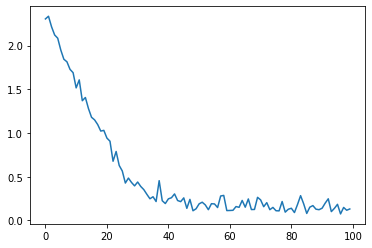

In [7]:
plt.plot(ppl.v('loss_history'))

In [8]:
config = {
#     'inputs/images/shape': IMAGE_SHAPE,
#     'inputs/labels/classes': 10,
#     'initial_block/inputs': 'images',
    'loss': ['ce', 'ce'],
    'decay': 'exp',
    'n_iters': 25,
    'train_steps': {'a': {}, 'b': {}},
    'initial_block': {'layout': 'fafaf', 'units': [128, 256, 10]},
    'order': ['initial_block', ('ib_2', 'initial_block', EagerTorch.initial_block)],
}


ppl = run('classification', EagerTorch, config, 'simple fc', n_iters=99, batch_size=64)

Loss is 0.49404: 100%|██████████| 99/99 [00:02<00:00, 46.04it/s]  

classification simple fc is done


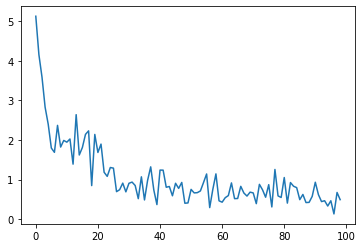

In [9]:
plt.plot(ppl.v('loss_history'))

In [10]:
from batchflow.models.eager_torch.layers import Combine

class TestModel(EagerTorch):
    @classmethod
    def body(cls, inputs, **kwargs):
        """ Truly amazing docstring. """
        kwargs = cls.get_defaults('body', kwargs)
        return BodyModule(inputs=inputs, **kwargs)
    
class BodyModule(nn.Module):
    def __init__(self, inputs=None, **kwargs):
        super().__init__()
        self.x1 = ConvBlock(inputs=inputs, **kwargs)
        self.x2 = ConvBlock(inputs=inputs, **kwargs)
        
        self.combine = Combine(op='concat')
        
    def forward(self, x):
        x1 = self.x1(x)
        x2 = self.x2(x)
        return self.combine([x1, x2])

In [11]:
config = {
    'initial_block': {'layout': 'Rcna. p cnap',
                      'filters': [16, 32], 'scale_factor': 2,},
#     'body': {'layout': 'ca'*2,
#              'filters': [32, 32]},
    'body': {'module': BodyModule, 'module_kwargs': {'layout': 'cnacna',
                                                     'filters': [32, 32]}
             },
    'head': {'layout': 'Dnfaf',
             'units': [600,10], 'dropout_rate': 0.3},
}

ppl = run('classification', TestModel, config, 'simple fc', n_iters=50, batch_size=64)

Loss is 0.1429511: 100%|██████████| 50/50 [00:06<00:00,  7.80it/s]

classification simple fc is done


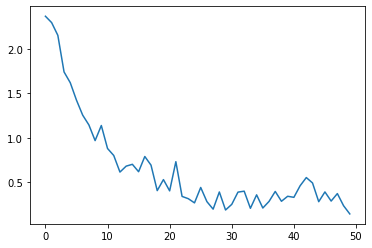

In [12]:
plt.plot(ppl.v('loss_history'))

In [13]:
test_pipeline = (mnist.test.p
                .import_model('MODEL', ppl)
                .init_variable('predictions')
                .init_variable('metrics', init_on_each_run=None) 
                .to_array(channels='first', dtype='float32')
#                 .train_model('MODEL', B.images, B.labels,
#                                fetches='predictions', save_to=V('predictions'))
                .predict_model('MODEL', B.images,
                               fetches='predictions', save_to=V('predictions'))
                .gather_metrics('class', targets=B.labels, predictions=V('predictions'),
                                fmt='logits', axis=-1, save_to=V('metrics', mode='w'))
                .run(64, shuffle=True, n_epochs=1, drop_last=False, bar=True)
)

100%|██████████| 157/157 [00:04<00:00, 33.74it/s]


In [14]:
metrics = test_pipeline.get_variable('metrics')
metrics.evaluate('accuracy')

0.9375

In [15]:
ppl.get_model_by_name('MODEL').model

Sequential(
  (initial_block): ConvBlock(
    (block_modules): ModuleList(
      (0): Sequential(
        (Layer 1, letter "c"; (None, 1, 28, 28) -> (None, 16, 28, 28)): Conv(
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
        )
        (Layer 2, letter "n"; (None, 16, 28, 28) -> (None, 16, 28, 28)): BatchNorm(
          (layer): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (Layer 3, letter "a"; (None, 16, 28, 28) -> (None, 16, 28, 28)): Activation(
          (activation): ReLU(inplace=True)
        )
      )
      (1): Sequential(
        (Layer 5, letter "p"; (None, 17, 28, 28) -> (None, 17, 14, 14)): Pool(
          (layer): MaxPool(
            (layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          )
        )
        (Layer 6, letter "c"; (None, 17, 14, 14) -> (None, 32, 14, 14)): Conv(
          (layer): Conv2d(17, 32, kernel_size=(3, 3), stride=(1, 1))
        )
 

# Segmentation

In [16]:
config = {
    'initial_block': {'layout': 'cna', 'filters': 8},
#     'body/encoder/num_stages': 3,
#     'body/encoder/single_return': False,
    'body/decoder/num_stages': 3,
#     'body/decoder/filters': [32, 48, 64],
    'body/decoder/factor': [1, 1, 1],
#     'head': {'layout': 'c', 'filters': 1,}
}

ppl = run('segmentation', Decoder, config, 'unet?', n_iters=10, batch_size=64)

Loss is 6440.979: 100%|██████████| 10/10 [00:00<00:00, 10.93it/s]

segmentation unet? is done


In [17]:
ppl.get_model_by_name('MODEL').model

Sequential(
  (initial_block): ConvBlock(
    (block_modules): ModuleList(
      (0): Sequential(
        (Layer 0, letter "c"; (None, 1, 28, 28) -> (None, 8, 28, 28)): Conv(
          (layer): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
        )
        (Layer 1, letter "n"; (None, 8, 28, 28) -> (None, 8, 28, 28)): BatchNorm(
          (layer): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (Layer 2, letter "a"; (None, 8, 28, 28) -> (None, 8, 28, 28)): Activation(
          (activation): ReLU(inplace=True)
        )
      )
    )
  )
  (body): DecoderModule(
    (decoder_b): ModuleList(
      (0): DefaultBlock(
        (layer): ConvBlock(
          (block_modules): ModuleList(
            (0): Sequential(
              (Layer 0, letter "c"; (None, 8, 28, 28) -> (None, 4, 28, 28)): Conv(
                (layer): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1))
              )
              (Layer 1, letter "n"; (None, 4, 28, 28) -> 

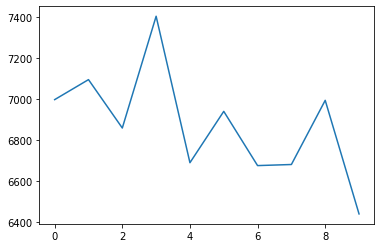

In [18]:
plt.plot(ppl.v('loss_history'))

In [ ]:
config = {
    'initial_block': {'layout': 'cna', 'filters': 8},
    'body/encoder/num_stages': 3,
#     'body/decoder/num_stages': 3,
#     'head': {'layout': 'c', 'filters': 1,}
}

ppl = run('segmentation', EncoderDecoder, config, 'unet?', n_iters=1000, batch_size=64)

Loss is 5974.434:  40%|███▉      | 399/1000 [03:20<04:56,  2.03it/s]

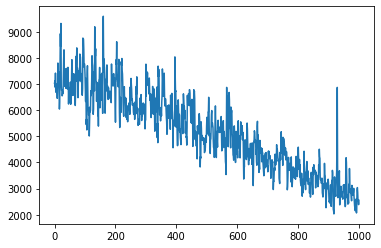

In [27]:
plt.plot(ppl.v('loss_history'))

In [21]:
config = {
    'step_on_each': 1,
    'initial_block': {
#         'layout': 'cnap AAbcna++ c',
        'layout': 'cnaRp cnaRp tna+ tna+ BScna*+ cnac',
        'filters': [16, 32, 32, 16, 'same', 8, 1],
        'transposed_conv': {'kernel_size': 2, 'strides': 2},
#         'kernel_size': [3, 3, 2, 2, 3, 3, 3],
#         'strides':     [1, 1, 2, 2, 1, 1, 1],
        'side_branch': {'layout': 'ca', 'filters': 'same'}
    },
}

ppl = run('segmentation', EagerTorch, config, 'unet?', n_iters=10, batch_size=64)

Loss is 6507.598: 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

segmentation unet? is done


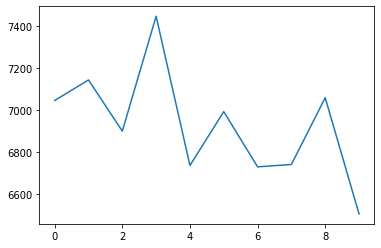

In [22]:
plt.plot(ppl.v('loss_history'))

In [23]:
ppl.get_model_by_name('MODEL').model

Sequential(
  (initial_block): ConvBlock(
    (block_modules): ModuleList(
      (0): Sequential(
        (Layer 0, letter "c"; (None, 1, 28, 28) -> (None, 16, 28, 28)): Conv(
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
        )
        (Layer 1, letter "n"; (None, 16, 28, 28) -> (None, 16, 28, 28)): BatchNorm(
          (layer): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (Layer 2, letter "a"; (None, 16, 28, 28) -> (None, 16, 28, 28)): Activation(
          (activation): ReLU(inplace=True)
        )
      )
      (1): Sequential(
        (Layer 4, letter "p"; (None, 16, 28, 28) -> (None, 16, 14, 14)): Pool(
          (layer): MaxPool(
            (layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          )
        )
        (Layer 5, letter "c"; (None, 16, 14, 14) -> (None, 32, 14, 14)): Conv(
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
        )
 

In [26]:
eval('same+5+np.array(10)', {}, {'same': 10})

NameError: name 'np' is not defined